In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append('../..')
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata
from itertools import combinations
import shap
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from utils.general import L_U_to_CI
from utils.feature_importance import get_shap_global
from utils.feature_ranking import confident_simultaneous_ranking, calc_t_test, multi_hypothesis_testing, calc_set_ranks
from utils.plot_ranking import plot_ranks
from experiments.real_data.preprocess_data import get_data_by_name
%matplotlib inline
sns.set_theme(style='whitegrid')

In [2]:
# Set all fonts' sizes
params = {'legend.fontsize': 32,
          'legend.title_fontsize': 32,
          'axes.labelsize': 36,
          'axes.titlesize':40,
          'xtick.labelsize':32,
          'ytick.labelsize':32, 
          'lines.linewidth': 4, 
          'figure.titlesize': 40}
pylab.rcParams.update(params)

# Avoid Type 3 fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
name = 'bike'
filepath = 'data/bike.csv'
out_path = r'../../figures/real_data/bike/'

bike, target_name = get_data_by_name(name, filepath)

In [4]:
bike.head()

,Year,Month,Day,Hour,Season,Holiday,Workingday,Weather,Temp,Atemp,Humidity,Windspeed,Count
0,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,16
1,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,40
2,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0,32
3,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0,13
4,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0,1


In [5]:
bike.drop(target_name, axis=1).corrwith(bike[target_name]).sort_values(key=abs)

Holiday      -0.005393
Workingday    0.011594
Day           0.019826
Windspeed     0.101369
Weather      -0.128655
Season        0.163439
Month         0.166862
Year          0.260403
Humidity     -0.317371
Atemp         0.389784
Temp          0.394454
Hour          0.400601
dtype: float64

In [6]:
drop_cols = ['Atemp', 'Season', 'Windspeed', 'Humidity', 'Holiday']
bike = bike.drop(drop_cols, axis=1)

In [7]:
bike.drop(target_name, axis=1).corrwith(bike[target_name])

Year          0.260403
Month         0.166862
Day           0.019826
Hour          0.400601
Workingday    0.011594
Weather      -0.128655
Temp          0.394454
dtype: float64

In [8]:
bike.shape

(10886, 8)

In [9]:
# Split data
train, test = train_test_split(bike, test_size=0.4, random_state=1)

X_train = train.drop(target_name, axis=1).reset_index(drop=True)
X_test = test.drop(target_name, axis=1).reset_index(drop=True)

Y_train = train[target_name].values
Y_test = test[target_name].values

print('train:', X_train.shape)
print('test:', X_test.shape)

train: (6531, 7)
test: (4355, 7)


In [10]:
feature_names = bike.columns.drop(target_name)
model = xgb.XGBRegressor(random_state=2023, objective='reg:squarederror')
model.fit(X_train, Y_train)

print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

explainer = shap.TreeExplainer(model)

0.9805753605878269
0.9414282386038328


In [11]:
colors = sns.color_palette("dark")
colors_7 = colors[:7]
np.random.seed(25)
np.random.shuffle(colors_7)
colors_map = {feature: colors_7[i] for i, feature in enumerate(feature_names)}

# Introduction motivation example

In [12]:
new_colors = colors_map.copy()

for feature in feature_names:
    if feature not in ('Month', 'Workingday'):
        new_colors[feature] = (0.8, 0.8, 0.8)

In [13]:
n = 50
sample_bike_50_1 = test.sample(n=n, random_state=2)
shap_vals_1 = explainer(sample_bike_50_1[feature_names])
means_order_1 = np.argsort(np.mean(np.abs(shap_vals_1.values), axis=0))[::-1]

sample_bike_50_2 = test.sample(n=n, random_state=3)
shap_vals_2 = explainer(sample_bike_50_2[feature_names])
means_order_2 = np.argsort(np.mean(np.abs(shap_vals_2.values), axis=0))[::-1]

count_order_1 = 0
count_order_2 = 0
rep = 1000
for i in range(rep):
    sample_i = test.sample(n=n, random_state=i + 1)
    shap_vals_i = explainer(sample_i[feature_names])
    means_order_i = np.argsort(np.mean(np.abs(shap_vals_i.values), axis=0))[::-1]
    if np.array_equal(means_order_i, means_order_1):
        count_order_1 += 1
    elif np.array_equal(means_order_i, means_order_2):
        count_order_2 += 1
    else:
        print('different order:', means_order_i)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


different order: [3 6 0 1 4 5 2]
different order: [3 6 0 1 4 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 6 0 4 1 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 6 0 1 4 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 6 0 4 1 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 0 4 6 1 5 2]
different order: [3 0 6 1 5 4 2]
different order: [3 0 4 6 1 5 2]
different order: [3 6 0 1 4 5 2]


In [14]:
ratio_order_1 = np.round((count_order_1 / rep) * 100, 2)
ratio_order_2 = np.round((count_order_2 / rep) * 100, 2)
ratio_order_1, ratio_order_2

(69.4, 29.1)

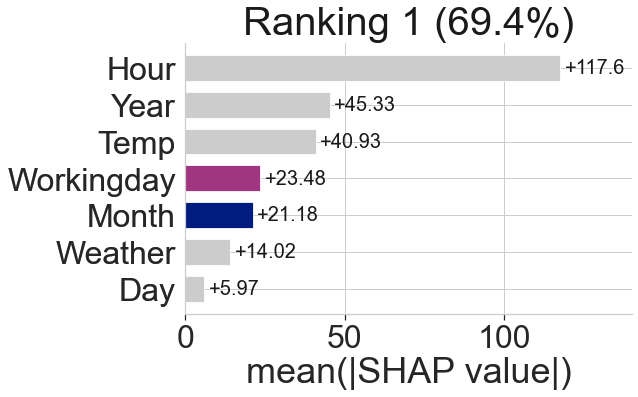

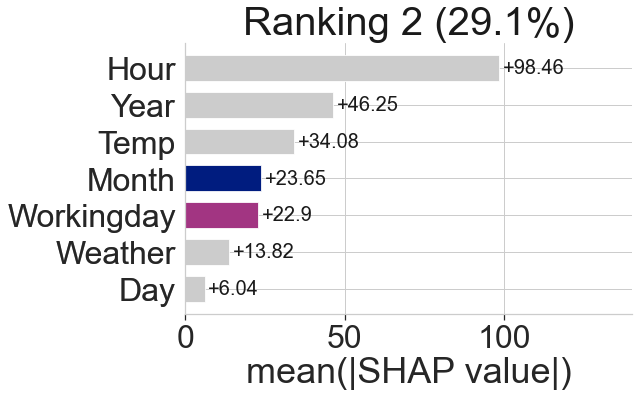

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.plots.bar(shap_vals_1, show=False)
for child in ax.get_children():
    if isinstance(child, mpl.text.Text):
        child.set(fontsize=20, color='k')
ax.tick_params(axis="both", labelsize=32)
ax.set_xlim(0, 140)
ax.xaxis.get_label().set_fontsize(36)
ax.set_title('Ranking 1 (' + str(ratio_order_1) + '%)')
for txt in fig.texts:
    txt.set_visible(False)
for p, color in zip(ax.patches, np.array(list(new_colors.values()))[means_order_1]):
    p.set_facecolor(color)

fig, ax = plt.subplots(figsize=(8, 6))
shap.plots.bar(shap_vals_2, show=False)
for child in ax.get_children():
    if isinstance(child, mpl.text.Text):
        child.set(fontsize=20, color='k')
ax.tick_params(axis="both", labelsize=32)
ax.set_xlim(0, 140)
ax.xaxis.get_label().set_fontsize(36)
ax.set_title('Ranking 2 (' + str(ratio_order_2) + '%)')
for p, color in zip(ax.patches, np.array(list(new_colors.values()))[means_order_2]):
    p.set_facecolor(color)

# Uncertainty as a function of base importance values

## Comparison of n=50 and n=1000

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


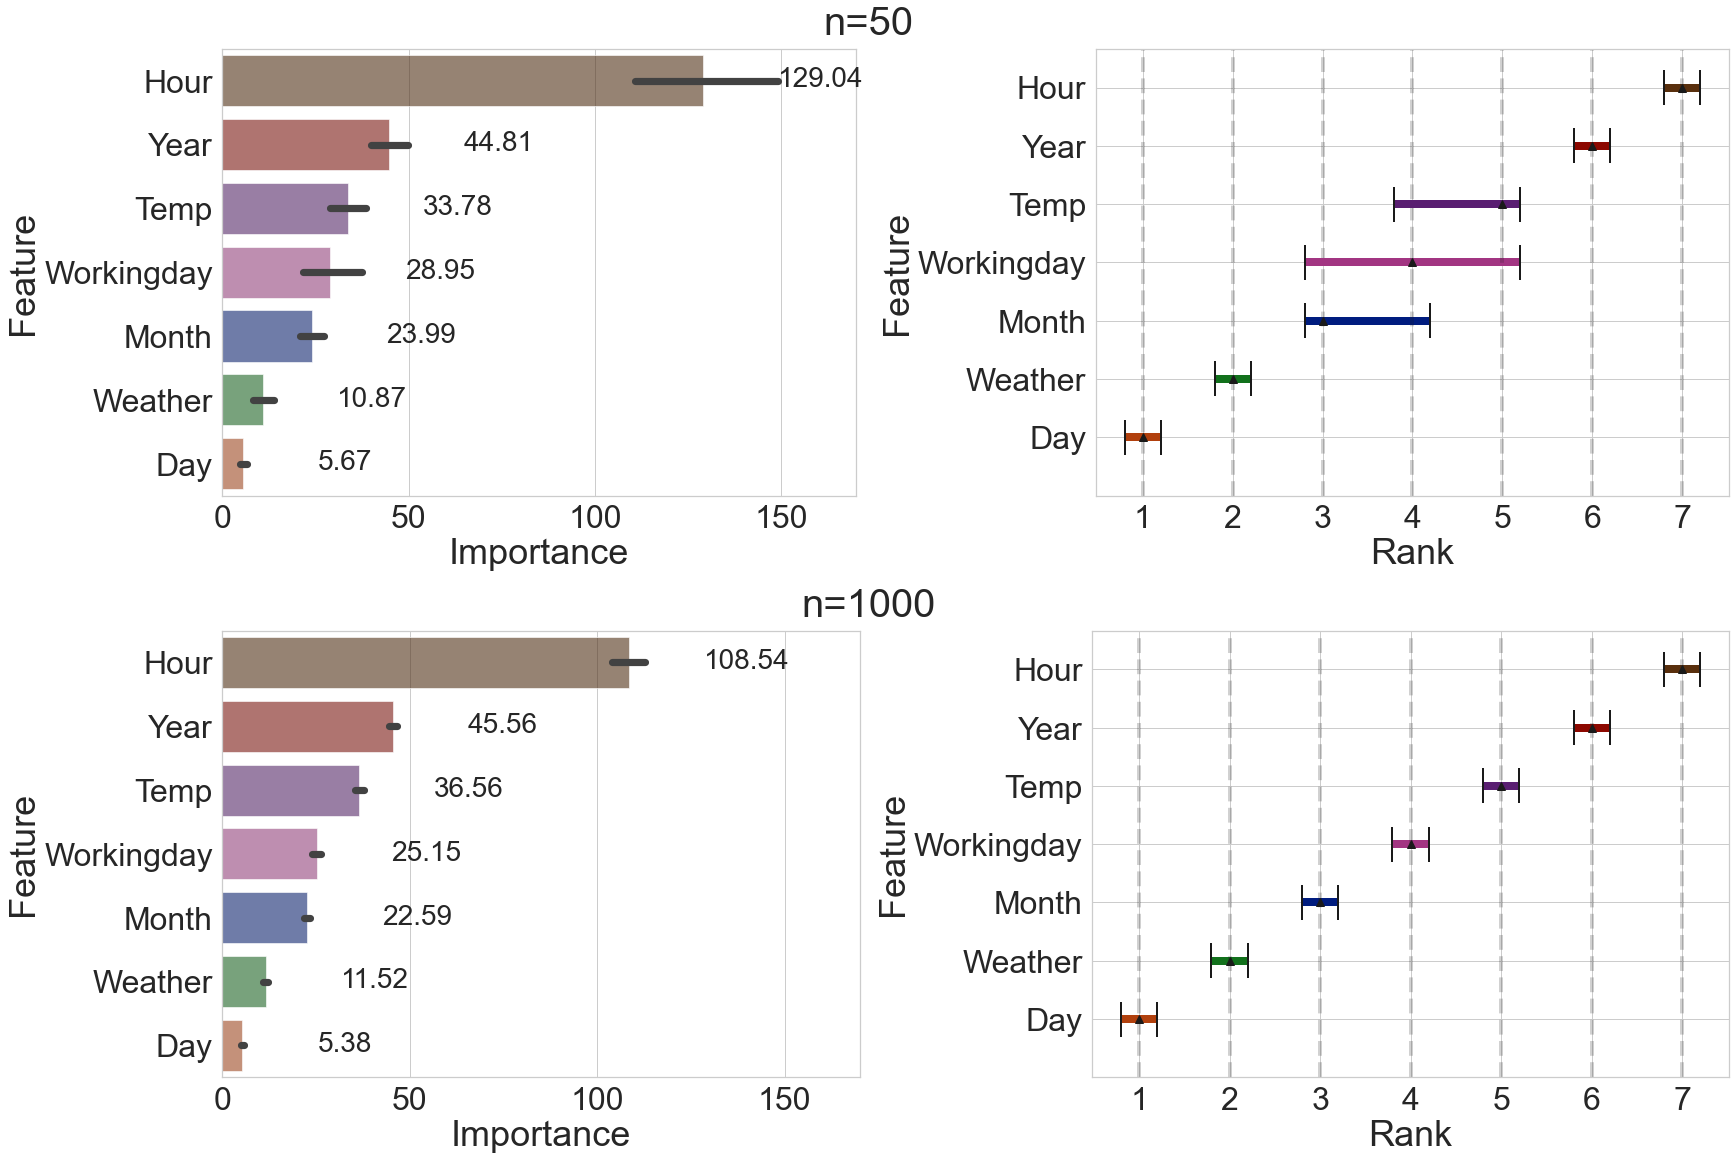

In [16]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(24, 16))
for ax in axs:
    ax.remove()
# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]
ns = [50, 1000]
for i, n in enumerate(ns):
    subfig = subfigs[i]
    subfig.suptitle('n=' + str(n))
    axs = subfig.subplots(nrows=1, ncols=2)
    sample_bike = test.sample(n=n, random_state=(i + 1)*n)
    shap_means, shap_means_std, shap_values = get_shap_global(explainer, 
                                                              sample_bike[feature_names],
                                                              return_local=True)
    base_importance = pd.DataFrame(np.abs(shap_values), columns=feature_names)
    naive_rank = (rankdata(shap_means)).astype(int)
    base_importance_long = base_importance.stack().reset_index().drop('level_0', axis=1)
    base_importance_long.columns = ['Feature', 'Importance']
    order_map = {feature: order for feature, order in zip(feature_names, (naive_rank - 1))}
    base_importance_sorted = base_importance_long.sort_values(by='Feature',
                                                              key=lambda x: x.map(order_map),
                                                              ascending=False)
    feature_ord = feature_names[np.argsort(shap_means)[::-1]]
    sns.barplot(x='Importance', y='Feature', data=base_importance_long, 
                estimator=np.mean, ci=90, ax=axs[0], alpha=0.6, 
                order=feature_ord, palette=colors_map)
    for l in axs[0].containers[0]:
        axs[0].text(l.get_width() + 20, l.get_y() + 0.5, np.round(l.get_width(), 2), fontsize=28)
    axs[0].set_xlim(0, 170)
    
    holm_rank = confident_simultaneous_ranking(base_importance.values, alpha=0.1, 
                                               method='holm', paired_test_func=calc_t_test)
    plot_ranks(holm_rank, shap_means, feature_names, ax=axs[1], colors_map=colors_map)

# Full example

In [17]:
seed = 50
n = 50
sample_bike = test.sample(n=n, random_state=seed)

In [18]:
shap_means, shap_means_std, shap_values = get_shap_global(explainer, 
                                                          sample_bike[feature_names],
                                                          return_local=True)
base_importance = pd.DataFrame(np.abs(shap_values), columns=feature_names)
naive_rank = (rankdata(shap_means)).astype(int)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [19]:
ranks_full_example = pd.DataFrame()
ranks_full_example['feature'] = feature_names
ranks_full_example['global_FI'] = shap_means.astype('float64').round(3)
ranks_full_example['observed_rank'] = naive_rank

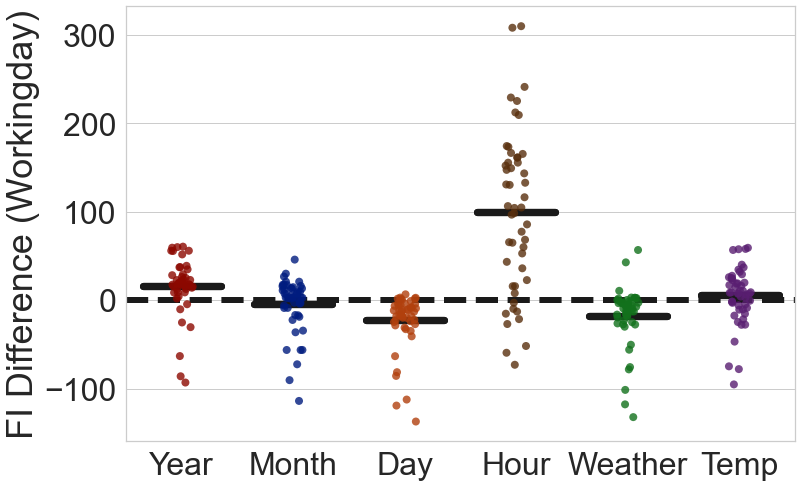

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
workingday_diffs = base_importance.sub(base_importance['Workingday'], axis=0).drop('Workingday', axis=1)
workingday_diffs_long = workingday_diffs.stack().reset_index().drop('level_0', axis=1)
workingday_diffs_long.columns = ['Feature', 'FI Difference (Workingday)']
spec = dict(x='Feature', y='FI Difference (Workingday)', data=workingday_diffs_long)
sns.stripplot(**spec, palette=colors_map, size=8, alpha=0.8, ax=ax)
sns.pointplot(**spec, join=False, ci=0, capsize=.7, scale=0, ax=ax, color='k')
ax.axhline(y=0, color='k', linestyle='--', linewidth=6)
ax.set_xlabel(None);

In [21]:
p = base_importance.shape[1]
t_test_res = calc_t_test(base_importance.values, alternative='less')
multi_res_holm = multi_hypothesis_testing(t_test_res, 0.1, 'holm')

In [22]:
feature_names_short = ['Y', 'M', 'D', 'H', 'WD', 'WX', 'TEMP']

In [23]:
rejection_res = pd.DataFrame(columns=range(1, p + 1), index=range(1, p + 1))
for pair in combinations(range(1 , p + 1), 2):
    j = pair[0]
    k = pair[1]
    test_res_jk = multi_res_holm[(multi_res_holm['var_1'] == j) & (multi_res_holm['var_2'] == k)]['reject'].values[0]
    test_res_kj = multi_res_holm[(multi_res_holm['var_1'] == k) & (multi_res_holm['var_2'] == j)]['reject'].values[0]
    if not (test_res_jk or test_res_kj):
        rejection_res.loc[j, k] = 0
        rejection_res.loc[k, j] = 0
    elif test_res_jk:
        rejection_res.loc[j, k] = -1
        rejection_res.loc[k, j] = 1
    else:
        rejection_res.loc[j, k] = 1
        rejection_res.loc[k, j] = -1
        
rejection_res.index = feature_names_short
rejection_res.columns = feature_names_short
rejection_res = rejection_res.astype(float)
rejection_res

,Y,M,D,H,WD,WX,TEMP
Y,NaN,1.0,1.0,-1.0,1.0,1.0,1.0
M,-1.0,NaN,1.0,-1.0,0.0,1.0,-1.0
D,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0
H,1.0,1.0,1.0,NaN,1.0,1.0,1.0
WD,-1.0,0.0,1.0,-1.0,NaN,1.0,0.0
WX,-1.0,-1.0,1.0,-1.0,-1.0,NaN,-1.0
TEMP,-1.0,1.0,1.0,-1.0,0.0,1.0,NaN


In [24]:
colors = ((0.5, 0.5, 0.5), (1, 1, 1), (0, 0, 0))
my_cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=3)

In [25]:
sign_map = {-1: '<', 1: '>', 0: '='}
def sign_to_str(sign):
    return sign_map[sign]

def plot_signs(signs_df, feature_names=None):
    f, ax = plt.subplots(figsize=(12, 8))
    colors = ((0.5, 0.5, 0.5), (1, 1, 1), (0, 0, 0))
    my_cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=3)
    sns.heatmap(signs_df, cmap=my_cmap, annot=True, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, ax=ax, cbar=False)
    for t in ax.texts: 
        t.set_text(sign_to_str(int(t.get_text())))
        t.set_fontsize(40)
    return f

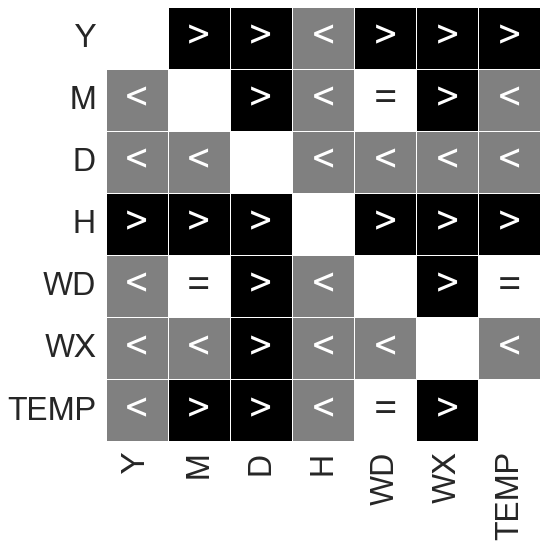

In [26]:
plot_signs(rejection_res);

In [27]:
holm_rank = calc_set_ranks(p, multi_res_holm)
ranks_full_example['CI'] = L_U_to_CI(holm_rank)
ranks_full_example.sort_values(by='observed_rank', ascending=False).reset_index(drop=True)

,feature,global_FI,observed_rank,CI
0,Hour,129.042,7,"[7, 7]"
1,Year,44.805,6,"[6, 6]"
2,Temp,33.777,5,"[4, 5]"
3,Workingday,28.950,4,"[3, 5]"
4,Month,23.987,3,"[3, 4]"
5,Weather,10.865,2,"[2, 2]"
6,Day,5.673,1,"[1, 1]"


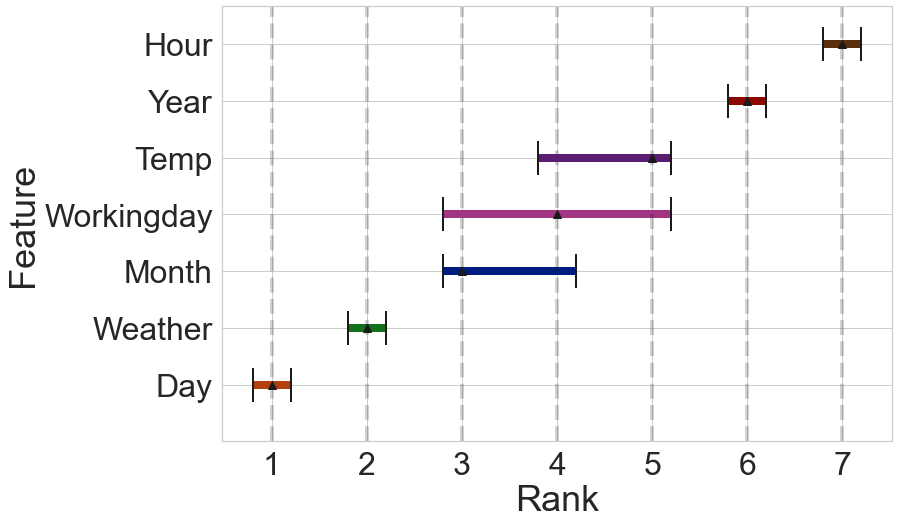

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_ranks(holm_rank, shap_means, feature_names, ax=ax, colors_map=colors_map);